In [1]:
classes=[]
with open('mini_classes.txt') as f:
    for line in f:
        classes.append(line)
print(classes)

['sun\n', 'tennis_racquet\n', 'cloud\n', 'star\n', 'apple\n', 'flower\n', 'cup\n', 'cat\n', 'sock\n', 'ice_cream']


In [2]:
classes=[c.replace('\n','').replace(' ','_') for c in classes]

In [35]:
#make a data directory where the quick draw data is stored.
!mkdir data

A subdirectory or file data already exists.


In [5]:
import urllib.request
def download():
#downloads data only for necessary classes
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [6]:
#download()
#uncomment when you first run the program to download data.Comment it again after that.

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tennis%20racquet.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flower.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ice%20cream.npy


In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [4]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [5]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [6]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [7]:
print(len(x_train))#40000 since 5000 images are taken for each class out of which 4000 are for train and 1000 for test

40000


In [8]:
print(len(y_train))

40000


In [9]:
print(len(y_test))

10000


In [10]:
print(len(y_train))

40000


In [11]:
print(len(x_test))

10000


tennis_racquet


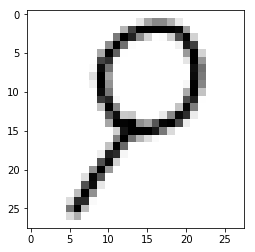

In [12]:
#show random image from quick draw downloaded data
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28),cmap='gray_r')#gray_r- to print in grayscale
print(class_names[int(y_train[idx].item())])

In [13]:
print(x_train.shape)

(40000, 784)


In [14]:
# Reshape and normalize
#Reshaping of x_train not needed since GAN expects the input in the same shape(...,784)
'''Reshaping of x_test,y_train_y_test not needed since GANs only need to look at the training data and the generator
and discriminator takes care of the rest'''
#127.5 used instead of 255 because it is normalized to btwn [-1,1] not [0,1]
x_train = (x_train.astype(np.float32) - 127.5)/127.5

In [15]:
# Network model architecture code- Adam optimizer used instead of gradient descent
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    generator.summary()
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    discriminator.summary()
    return discriminator

In [16]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [23]:
#Not working completely since optimizer state isn't saved so can't be used for further training
def save_model(model,model_name):
    model.save('/models'+model_name+'h5')

In [27]:
# Functions to generate and save a set of doodles as 1 image
def plot_generated_images(epoch, generator, examples=25, dim=(5, 5), figsize=(5, 5)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    %matplotlib inline
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

GENERATOR MODEL
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 784)               80360

100%|████████████████████████████████████████| 312/312 [00:55<00:00,  6.18it/s]


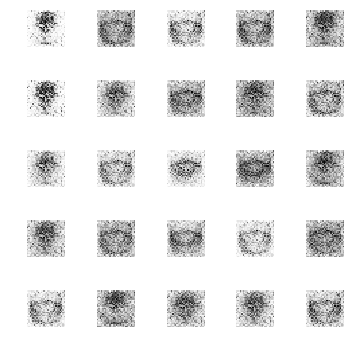

In [28]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    #x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    print('GENERATOR MODEL')
    generator = get_generator(adam)
    print('DISCRIMINATOR MODEL')
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        #generate image set after 1st epoch and then after every epoch div. by 20
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
    
    #save models after training. Important-not working fully.
    #save_model(generator,'generator')
    #save_model('discriminator')
    #save_model('gan')
    

if __name__ == '__main__':
    train(1, 128)#2 is the number of epochs it runs for